<b>Contents:</b>

[1  Load data 2014-2016 years](#section_1)

[2  Data preprocessing](#section_2)

[3  Setting coefficients to calculate the number of trips in the past.](#section_3)

[4  Setting SARIMA predictions as the feature](#section_4)

[5  Mastering new features](#section_5)

[6  Setting the parameters of the regression model](#section_6)

[7  May and June forecasting](#section_7)


In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import glob
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from xgboost import plot_importance

import matplotlib.pyplot as plt
%pylab inline
from sklearn.metrics import r2_score
from IPython.display import Image
import warnings
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from itertools import product
from datetime import datetime
import numpy as np
import calendar
from datetime import timedelta
from sklearn import metrics

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [24]:
# list of clusters
cluster_list_0=['1075', '1076', '1077', '1125', '1126', '1127', '1131', '1132', '1179',
       '1180', '1181', '1183', '1184', '1230', '1231', '1232', '1233', '1234',
       '1235', '1279', '1280', '1281', '1282', '1283', '1284', '1285', '1286',
       '1287', '1331', '1332', '1333', '1334', '1335', '1336', '1337', '1338',
       '1382', '1383', '1384', '1385', '1386', '1434', '1684', '1734', '1783']
cluster_list_1=['1128', '1129', '1130', '1176', '1177', '1178', '1221', '1222', '1223',
       '1227', '1228', '1229', '1272', '1273', '1274', '1278', '1326', '1327',
       '1376', '1377', '1378', '1380', '1426', '1532', '1533', '1630']
cluster_list_2=['1172', '1173', '1174', '1175', '1182', '1224', '1225', '1339', '1387',
       '1388', '1389', '1390', '1431', '1435', '1436', '1437', '1438', '1439',
       '1441', '1442']
cluster_list_3=['1733', '2068', '2069', '2118', '2119', '2168']
cluster_list_4=['1480', '1482', '1483', '1530', '1580']
# the nearest time series to each cluster center
ts_cl_0='1334'
ts_cl_1='1326'
ts_cl_2='1387'
ts_cl_3='2068'
ts_cl_4='1530'

<a id='section_1'></a>
# Load data 2014-2016 years

In [25]:
trips_2016=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_16_preprocessing/grouped_region_2016_full.csv', index_col='index')
trips_2016.index=pd.to_datetime(trips_2016.index)
trips_2015=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_15_preprocessing/grouped_region_2015_full.csv', index_col='index')
trips_2015.index=pd.to_datetime(trips_2015.index)
trips_2014=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_14_preprocessing/grouped_region_2014_full.csv', index_col='index')
trips_2014.index=pd.to_datetime(trips_2014.index)

In [26]:
trips_2016.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
index,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80,144,50,77,319,402,531,617,846,267,...,12,0,2,44,5,41,4,70,7,66
2016-01-01 01:00:00,91,211,49,134,404,420,370,453,594,224,...,29,0,5,2,2,4,0,47,1,29


In [27]:
col_list=trips_2016.columns

In [28]:
col_list

Index(['1075', '1076', '1077', '1125', '1126', '1127', '1128', '1129', '1130',
       '1131',
       ...
       '1630', '1684', '1733', '1734', '1783', '2068', '2069', '2118', '2119',
       '2168'],
      dtype='object', length=102)

<a id='section_2'></a>
# Data preprocessing

In [29]:
# holydays features prerocessing
# holydays features depending on the days of the week¶
def date_calculate(year):
    date_list=[]
    for y,i,j in zip(usa_holidays['2020'].dt.month.tolist(),usa_holidays['number_of_week'].tolist(), usa_holidays['day_of_week'].tolist()  ):
    
        if calendar.monthcalendar(year,y)[0][j] ==0:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i+1][j])
        else:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i][j])
        date_list.append(res)
    return date_list 
# loading holyday tab from internet
base_url ='https://www.officeholidays.com/countries/usa/2020'
df_list = pd.read_html(base_url, flavor='html5lib')
usa_holidays=df_list[0]


# delete the row as it is the holiday in another state
usa_holidays=usa_holidays.drop([11])
# Add new columns for rolling holidays date transformation
usa_holidays['2020']='2020 '+usa_holidays['Date']
usa_holidays['2020']=pd.to_datetime(usa_holidays['2020']) 
usa_holidays['day_of_week']=0
usa_holidays['number_of_week']=0
#  Leave only rows with dates depending on the days of the week
criteria_1=usa_holidays.Comments.notna()
usa_holidays_1=usa_holidays[criteria_1]
list_of_days=[5,0,0,6,0,6,5,5,5,5,0,0,5,5,3,4,5,5,5]
list_of_weeks_numbers=[0,2,2,1,3,2,0,0,0,0,0,1,0,0,3,3,0,0,0]

usa_holidays.loc[:, 'day_of_week']=list_of_days
usa_holidays.loc[:, 'number_of_week']=list_of_weeks_numbers
usa_holidays['2014']=date_calculate(2014)
usa_holidays['2015']=date_calculate(2015)
usa_holidays['2016']=date_calculate(2016)
# Add the columns with other holidays
usa_holidays['2016_2']='2016 '+usa_holidays['Date']
usa_holidays['2016_2']=pd.to_datetime(usa_holidays['2016_2'])


usa_holidays['2015_2']='2015 '+usa_holidays['Date']
usa_holidays['2015_2']=pd.to_datetime(usa_holidays['2015_2'])


usa_holidays['2014_2']='2014 '+usa_holidays['Date']
usa_holidays['2014_2']=pd.to_datetime(usa_holidays['2014_2'])
# Join dates
usa_holidays['2014'] = np.where(~criteria_1, usa_holidays['2014_2'], usa_holidays['2014'])
usa_holidays['2015'] = np.where(~criteria_1, usa_holidays['2015_2'], usa_holidays['2015'])
usa_holidays['2016'] = np.where(~criteria_1, usa_holidays['2016_2'], usa_holidays['2016'])
#  Delete temporarily used columnsи
usa_holidays=usa_holidays.iloc[:,[8,9,10]]
# Add columns with pre- and day after the holiday
delta=timedelta(days=1)
usa_holidays=usa_holidays['2014'].append(usa_holidays['2015']).append(usa_holidays['2016'])
usa_holidays=usa_holidays.to_frame(name='holidays')
usa_holidays['day_before']=usa_holidays['holidays']-delta
usa_holidays['day_after']=usa_holidays['holidays']+delta
hol_list_hol=usa_holidays.holidays.tolist()
hol_list_before=usa_holidays.day_before.tolist()
hol_list_after=usa_holidays.day_after.tolist()

## load data
def load_data(num_ts):
    grouped_index_16=trips_2016[num_ts]
    grouped_index_15=trips_2015[num_ts]
    grouped_index_14=trips_2014[num_ts]
    grouped_index_14_16=grouped_index_14\
        .append(grouped_index_15)\
        .append(grouped_index_16)
    
    grouped_index_14_16.name='Count'
    
    return grouped_index_14_16

# Check and input missing values

def data_check(series):
    date_rng = pd.date_range(start='2014-01-01', end='2016-06-30 23:00:00', freq='H')
    grouped_index_14_16_add=pd.DataFrame({'Count': 0},index=date_rng )
    series=series.sort_index()
    series=series.to_frame().append(grouped_index_14_16_add)
    grouped=series.groupby(series.index)['Count'].sum().to_frame()
    return grouped

#Find the average values and replace with them data for 2016 for the 
#observed period
def data_storm(series_2):
    list_to_change=((series_2.loc['2015-01-24 05:00:00':'2015-01-26 09:00:00'].Count.values+series_2.loc['2014-01-25 05:00:00':'2014-01-27 09:00:00'].Count.values)/2).astype('int')
    series_2.loc['2016-01-23 05:00:00':'2016-01-25 09:00:00','Count']=list_to_change
    grouped=series_2
    return grouped

# Feature mastering
## Adding holidays
def add_holidays(series_3):
    criteria_hol=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_hol)
    criteria_before=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_before)
    criteria_after=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_after)
    series_3['hol']=np.where(criteria_hol, 1, 0)
    series_3['before_hol']=np.where(criteria_before, 1, 0)
    series_3['after_hol']=np.where(criteria_after, 1, 0)
    grouped=series_3
    return grouped

## Adding intercept, day, week and year's features
def add_features(series_4):
    
    # intercept
    series_4['w_0']=1
    T=len(series_4)
    t=np.linspace(1,T, T)
    # week features
    for j in range(50):
        i=j+1
        name='sw_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/168)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cw_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/168)
        series_4[name]=new_column_values
     # year's features
    for j in range(50):
        i=j+1
        name='sy_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/8766)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cy_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/8766)
        series_4[name]=new_column_values
         # day features
    for j in range(50):
        i=j+1
        name='sh_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/24)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='ch_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/24)
        series_4[name]=new_column_values
    grouped=series_4
    return grouped
    
## selecting the most important features
def feature_selection(series_5, num_features):
    x=series_5.loc[:'2016.04.30 23:00','hol':]
    y=np.array(series_5.loc[:'2016.04.30 23:00','Count']).reshape(-1)
    #apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=num_features)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    return grouped

## splitting data for training and testing sets
def split_data(series_6):
    
    ## intervals till the end of april
    train_sarimax=series_6.loc[:'2016-04-30 23:00']
    x_train_sarimax=train_sarimax.iloc[:,1:]
    y_train_sarimax=train_sarimax.iloc[:,0]
    
    ## intervals till the end of may
    train=series_6.loc[:'2016-06-30 23:00']
    x_train=train.iloc[:,1:]
    y_train=train.iloc[:,0]

    ## test sample
    test=series_6.loc['2016-05-01':]
    return x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax

# Combining all 
def data_preprocessing(num_ts, num_features):
    warnings.filterwarnings('ignore')
    grouped=load_data(num_ts)
    grouped=data_check(grouped)
    grouped= data_storm(grouped)
    grouped=add_holidays(grouped)
    grouped=add_features(grouped)
    grouped=feature_selection(grouped, num_features)
    x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax =split_data(grouped)
    return grouped,  x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax
                              

def date_calculate(year):
    date_list=[]
    for y,i,j in zip(usa_holidays['2020'].dt.month.tolist(),usa_holidays['number_of_week'].tolist(), usa_holidays['day_of_week'].tolist()  ):
    
        if calendar.monthcalendar(year,y)[0][j] ==0:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i+1][j])
        else:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i][j])
        date_list.append(res)
    return date_list 
# loading holyday tab from internet
base_url ='https://www.officeholidays.com/countries/usa/2020'
df_list = pd.read_html(base_url, flavor='html5lib')
usa_holidays=df_list[0]


# delete the row as it is the holiday in another state
usa_holidays=usa_holidays.drop([11])
# Add new columns for rolling holidays date transformation
usa_holidays['2020']='2020 '+usa_holidays['Date']
usa_holidays['2020']=pd.to_datetime(usa_holidays['2020']) 
usa_holidays['day_of_week']=0
usa_holidays['number_of_week']=0
#  Leave only rows with dates depending on the days of the week
criteria_1=usa_holidays.Comments.notna()
usa_holidays_1=usa_holidays[criteria_1]
list_of_days=[5,0,0,6,0,6,5,5,5,5,0,0,5,5,3,4,5,5,5]
list_of_weeks_numbers=[0,2,2,1,3,2,0,0,0,0,0,1,0,0,3,3,0,0,0]

usa_holidays.loc[:, 'day_of_week']=list_of_days
usa_holidays.loc[:, 'number_of_week']=list_of_weeks_numbers
usa_holidays['2014']=date_calculate(2014)
usa_holidays['2015']=date_calculate(2015)
usa_holidays['2016']=date_calculate(2016)
# Add the columns with other holidays
usa_holidays['2016_2']='2016 '+usa_holidays['Date']
usa_holidays['2016_2']=pd.to_datetime(usa_holidays['2016_2'])


usa_holidays['2015_2']='2015 '+usa_holidays['Date']
usa_holidays['2015_2']=pd.to_datetime(usa_holidays['2015_2'])


usa_holidays['2014_2']='2014 '+usa_holidays['Date']
usa_holidays['2014_2']=pd.to_datetime(usa_holidays['2014_2'])
# Join dates
usa_holidays['2014'] = np.where(~criteria_1, usa_holidays['2014_2'], usa_holidays['2014'])
usa_holidays['2015'] = np.where(~criteria_1, usa_holidays['2015_2'], usa_holidays['2015'])
usa_holidays['2016'] = np.where(~criteria_1, usa_holidays['2016_2'], usa_holidays['2016'])
#  Delete temporarily used columnsи
usa_holidays=usa_holidays.iloc[:,[8,9,10]]
# Add columns with pre- and day after the holiday
delta=timedelta(days=1)
usa_holidays=usa_holidays['2014'].append(usa_holidays['2015']).append(usa_holidays['2016'])
usa_holidays=usa_holidays.to_frame(name='holidays')
usa_holidays['day_before']=usa_holidays['holidays']-delta
usa_holidays['day_after']=usa_holidays['holidays']+delta
hol_list_hol=usa_holidays.holidays.tolist()
hol_list_before=usa_holidays.day_before.tolist()
hol_list_after=usa_holidays.day_after.tolist()

## load data
def load_data(num_ts):
    grouped_index_16=trips_2016[num_ts]
    grouped_index_15=trips_2015[num_ts]
    grouped_index_14=trips_2014[num_ts]
    grouped_index_14_16=grouped_index_14\
        .append(grouped_index_15)\
        .append(grouped_index_16)
    
    grouped_index_14_16.name='Count'
    
    return grouped_index_14_16

# Check and input missing values
def data_check(series):
    date_rng = pd.date_range(start='2014-01-01', end='2016-06-30 23:00:00', freq='H')
    grouped_index_14_16_add=pd.DataFrame({'Count': 0},index=date_rng )
    series=series.sort_index()
    series=series.to_frame().append(grouped_index_14_16_add)
    grouped=series.groupby(series.index)['Count'].sum().to_frame()
    return grouped

#Find the average values and replace with them data for 2016 for the 
#observed period
def data_storm(series_2):
    list_to_change=((series_2.loc['2015-01-24 05:00:00':'2015-01-26 09:00:00'].Count.values+series_2.loc['2014-01-25 05:00:00':'2014-01-27 09:00:00'].Count.values)/2).astype('int')
    series_2.loc['2016-01-23 05:00:00':'2016-01-25 09:00:00','Count']=list_to_change
    grouped=series_2
    return grouped

# Feature mastering
## Adding holidays
def add_holidays(series_3):
    criteria_hol=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_hol)
    criteria_before=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_before)
    criteria_after=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_after)
    series_3['hol']=np.where(criteria_hol, 1, 0)
    series_3['before_hol']=np.where(criteria_before, 1, 0)
    series_3['after_hol']=np.where(criteria_after, 1, 0)
    grouped=series_3
    return grouped

## Adding intercept, day, week and year's features
def add_features(series_4):
    
    # intercept
    series_4['w_0']=1
    T=len(series_4)
    t=np.linspace(1,T, T)
    # week features
    for j in range(50):
        i=j+1
        name='sw_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/168)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cw_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/168)
        series_4[name]=new_column_values
     # year's features
    for j in range(50):
        i=j+1
        name='sy_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/8766)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cy_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/8766)
        series_4[name]=new_column_values
         # day features
    for j in range(50):
        i=j+1
        name='sh_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/24)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='ch_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/24)
        series_4[name]=new_column_values
    grouped=series_4
    return grouped
    
## selecting the most important features
def feature_selection(series_5, num_features):
    x=series_5.loc[:'2016.04.30 23:00','hol':]
    y=np.array(series_5.loc[:'2016.04.30 23:00','Count']).reshape(-1)
    #apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=num_features)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    return grouped

## splitting data for training and testing sets
def split_data(series_6):
    
    ## intervals till the end of april
    train_sarimax=series_6.loc[:'2016-04-30 23:00']
    x_train_sarimax=train_sarimax.iloc[:,1:]
    y_train_sarimax=train_sarimax.iloc[:,0]
    
    ## intervals till the end of june
    train=series_6.loc[:'2016-06-30 23:00']
    x_train=train.iloc[:,1:]
    y_train=train.iloc[:,0]

    ## test sample
    test=series_6.loc['2016-05-01':]
    return x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax

# Combining all
def data_preprocessing(num_ts, num_features):
    warnings.filterwarnings('ignore')
    grouped=load_data(num_ts)
    grouped=data_check(grouped)
    grouped= data_storm(grouped)
    grouped=add_holidays(grouped)
    grouped=add_features(grouped)
    grouped=feature_selection(grouped, num_features)
    x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax =split_data(grouped)
    return grouped,  x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax
                              


<a id='section_3'></a>
# Setting coefficients to calculate the number of trips in the past.

In [8]:
ts_cl_0='1334'
ts_cl_1='1326'
ts_cl_2='1387'
ts_cl_3='2068'
ts_cl_4='1530'

In [9]:
num_ts=ts_cl_0
num_features=80
# для подбора K использую данные до апреля 2016 года включительно
df=data_preprocessing(num_ts, num_features)[6] 
df=df.to_frame()


In [10]:
df.tail(2)

,Count
2016-04-30 22:00:00,401
2016-04-30 23:00:00,320


In [11]:
# количество поездок в моменты времени K кратные часам
tdelta=timedelta(hours=1)
K=24
for j in range(K):
        i=j+1
        name='shift_H'+str(i)
        new_column_values=df.Count.shift(i)
        df[name]=new_column_values

[0.6822971  0.00274827 0.0149093  0.00397262 0.04870009 0.06781505
 0.00934343 0.00208569 0.00720461 0.00831515 0.00428599 0.003338
 0.0034775  0.0042899  0.00648824 0.00332482 0.00304478 0.00603329
 0.03633457 0.01355894 0.01716718 0.00543825 0.00968982 0.03613751]


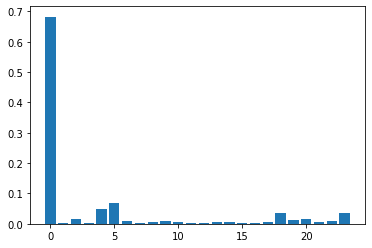

In [12]:
# проверяю значимость признаков 
# split data into X and y
X = df.iloc[K:,1:]
y = df.iloc[K:,:1:]
# fit model on training data
model = XGBRegressor()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

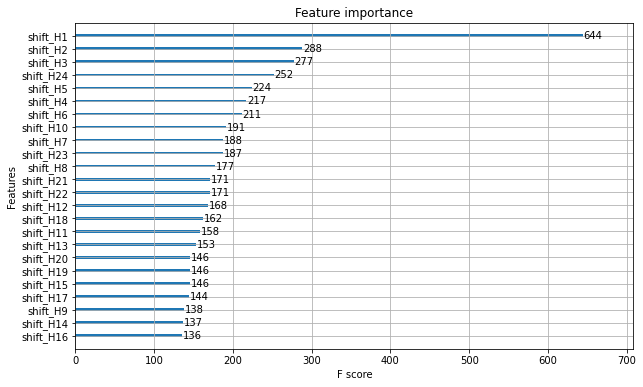

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(model,ax=ax)
pyplot.show()

Set K=24

In [14]:
num_ts=ts_cl_0
num_features=80
# для подбора K использую данные до апреля 2016 года включительно
df=data_preprocessing(num_ts, num_features)[6] 
df=df.to_frame()

# количество поездок в моменты времени Kd кратные дням
tdelta=timedelta(hours=1)
Kd=20
for j in range(Kd):
        i=j+1
        name='shift_D'+str(i)
        new_column_values=df.Count.shift(i*24)
        df[name]=new_column_values

[0.02770545 0.00309937 0.00492586 0.00347772 0.00491415 0.01090067
 0.823164   0.00463583 0.00537711 0.00300183 0.00328699 0.00376202
 0.00312264 0.07573145 0.00298191 0.00329267 0.00316179 0.00281091
 0.00310961 0.00753801]


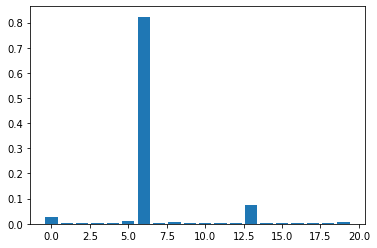

In [15]:
# проверяю значимость признаков 
# split data into X and y
X = df.iloc[Kd*24:,1:]
y = df.iloc[Kd*24:,:1:]
# fit model on training data
model = XGBRegressor()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

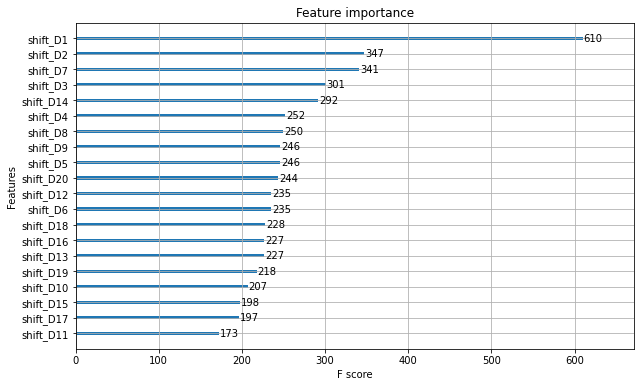

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(model,ax=ax)
pyplot.show()

Kd=20

<a id='section_4'></a>
# Setting SARIMA predictions as the feature

In [236]:
def calculate_ts(ts,param_2):
    param_2=param_2
    start_time=param_2[0]
    d=param_2[1]
    D=param_2[2]
    parameters_list = list([param_2[3]])
    reserv_param=param_2[4]
    s=param_2[5]
    num_features=param_2[6]

    cluster_0=data_preprocessing(ts, num_features)
    grouped_0=cluster_0[0]

    ## feature interval till the end of may
    x_train_0=cluster_0[1]

    ## trip's interval till the end of may
    y_train_0=cluster_0[2]

    ## complite dataset till the end of may
    train_0=cluster_0[3]

    ## ---------------------------------

     ## feature interval till the end of april
    x_train_sarimax=cluster_0[5]

    ## trip's interval till the end of april
    y_train_sarimax=cluster_0[6]
    
    ## complite dataset till the end of april
    train_sarimax=cluster_0[7]

    ## --------------------------------------

    ## test sample may-june
    test_data=cluster_0[4]
    train=train_0

    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    train_data=y_train_0[start_time:]
    exog_data=x_train_0[start_time:]

    for param in parameters_list:
        
        try:
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
        
        except ValueError:
            print('wrong parameters:', param)
            param=reserv_param
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
            best_model = model
            continue
        
        except LinAlgError:
            print('singularity parameters:', param)
            param=reserv_param
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
            best_model = model
            continue
        
    
    
        best_model = model
        predicted=best_model.fittedvalues #, exog=exog_data)

    return predicted

In [ ]:

## list of clusters
cluster_list=[cluster_list_0, 
              cluster_list_1, 
              cluster_list_2,
              cluster_list_3,
              cluster_list_4]
## cluster training parametrs
## 
param_list=[('2014-01-01',0,1,[1, 0, 1, 0],[2, 0, 2, 0], 12, 40), 
            ('2014-01-01',0,1,[1, 0, 1, 0],[0, 2, 0, 2], 12, 40), 
            ('2014-01-01',0,1,[1, 0, 1, 0],[0, 0, 1, 4], 12, 40), 
            ('2014-01-01',0,1,[0, 0, 1, 4],[0, 0, 0, 3], 12, 40), 
            ('2014-01-01',0,1,[3, 0, 1, 0],[2, 0, 1, 0], 12, 40)]

warnings.simplefilter('ignore')

for condition, param in zip(cluster_list, param_list):
    list_columns_cl_2=condition
    param_2=param
    
    for ts in list_columns_cl_2:
        warnings.simplefilter('ignore')
    
        predicted =calculate_ts(ts,param_2)
        series=pd.Series(predicted)
        # Полученные результаты значений предсказаний сохраняю на диск
        series.index.name='id'
        series.name='sarima'  
        f_name=ts+'_sarima'+'.csv'
        series.to_csv(f_name, sep = ',')

Save the results to the disc

<a id='section_5'></a>
# Mastering new features

In [17]:
def data_preprocessing_stage_2(num_ts,num_features):
    # Adding SARIMA predictions as new features
    series_7=data_preprocessing(num_ts, num_features)
    df=series_7[0]
    f_name=num_ts+'_sarima'+'.csv'
    sarima_features=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W5/Step_2_create_ARIMA_feat/'+f_name, index_col='id')
    sarima_features.index=pd.to_datetime(sarima_features.index)
    df=df.assign(sarima=sarima_features.sarima)
    # Adding new features depending from data
    # year's features
    df=df.assign(y_f=df.index.year-2014)
    # month's features
    df=df.assign(mnth_sin=(np.sin((df.index.month-1)*(2.*np.pi/12))))
    df=df.assign(mnth_cos=(np.cos((df.index.month-1)*(2.*np.pi/12))))
    # day's features
    df=df.assign(d_f=df.index.day)
    # hour's features
    df= df.assign(hr_sin=np.sin(df.index.hour*(2.*np.pi/24)))
    df= df.assign(hr_cos=np.cos(df.index.hour*(2.*np.pi/24)))
    # the number of day in the year
    df=df.assign(yd_f=df.index.dayofyear)
    # the number of week in the year
    df=df.assign(wk_f=df.index.weekofyear)
    # day of week
    df=df.assign(wd_sin=np.sin(df.index.dayofweek*(2.*np.pi/7)))
    df=df.assign(wd_cos=np.cos(df.index.dayofweek*(2.*np.pi/7)))
    # check is this a start of the month
    df=df.assign(ms_f=df.index.is_month_start*1)
    # check is this a start of the quarter
    df=df.assign(qs_f=df.index.is_quarter_start*1)
    # the number of quarter
    df=df.assign(qs_sin=np.sin((df.index.quarter-1)*(2.*np.pi/4)))
    df=df.assign(qs_cos=np.cos((df.index.quarter-1)*(2.*np.pi/4)))
    # summary and avarege number of travels for 12 hours, 24 hours and etc.
    df=df.assign(rol_12s=df.Count.rolling(12).sum())
    df=df.assign(rol_24s=df.Count.rolling(24).sum())
    df=df.assign(rol_168s=df.Count.rolling(168).sum())
    df=df.assign(rol_720s=df.Count.rolling(720).sum())
    df=df.assign(rol_12m=df.Count.rolling(12).mean())
    df=df.assign(rol_24m=df.Count.rolling(24).mean())
    df=df.assign(rol_168m=df.Count.rolling(168).mean())
    df=df.assign(rol_720m=df.Count.rolling(720).mean())
    # the number of trips in the past
    tdelta=timedelta(hours=1)
    K=24
    for j in range(K):
        i=j+1
        name='shift_H'+str(i)
        new_column_values=df.Count.shift(i)
        df[name]=new_column_values
    #
    tdelta=timedelta(hours=1)
    Kd=20
    for j in range(Kd):
        i=j+1
        name='shift_D'+str(i)
        new_column_values=df.Count.shift(i*24)
        df[name]=new_column_values
    #One hot encoding for clusters
    oh_0=int(num_ts in cluster_list_0)
    oh_1=int(num_ts in cluster_list_1)
    oh_2=int(num_ts in cluster_list_2)
    oh_3=int(num_ts in cluster_list_3)
    oh_4=int(num_ts in cluster_list_4)
    df=df.assign(oh_0=oh_0,
            oh_1=oh_1,
            oh_2=oh_2,
            oh_3=oh_3,
            oh_4=oh_4)
       
    df=df.dropna()
    # sample till the end of april
    df_a=df[:'2016-04-30 23:00:00']
    # sample till the end of may
    df_m=df[:'2016-05-31 23:00:00']
    #complite sample
    df_j=df[:'2016-06-30 23:00:00']
    # Creating samples for 1-6 hours forecasting in feature
    sample_1=df_j
    shift_1=sample_1.Count.shift(-1)
    sample_1.Count=shift_1
    
    sample_2=sample_1.dropna()
    shift_2=sample_2.Count.shift(-1)
    sample_2.Count=shift_2
    
    sample_3=sample_2.dropna()
    shift_3=sample_3.Count.shift(-1)
    sample_3.Count=shift_3

    sample_4=sample_3.dropna()
    shift_4=sample_4.Count.shift(-1)
    sample_4.Count=shift_4

    sample_5=sample_4.dropna()
    shift_5=sample_5.Count.shift(-1)
    sample_5.Count=shift_5

    sample_6=sample_5.dropna()
    shift_6=sample_6.Count.shift(-1)
    sample_6.Count=shift_6
    
    
    return df_a, sample_1, sample_2, sample_3, sample_4, sample_5, sample_6, df_m, df_j, df

<a id='section_6'></a>
# Setting the parameters of the regression model

In [18]:
def tune_regression(data):
    train=data
    X=np.array(train.iloc[:,1:])
    Y=np.array(train.iloc[:,:1]).reshape(-1)
    xgb1 = XGBRegressor()
    parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': range(1,6,2), # Used to control over-fitting
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

    xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    xgb_grid.fit(X,Y)

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    res=list(xgb_grid.best_params_.values())
    
    #  Gamma specifies the minimum loss reduction required to make a split.
    xgb2 = XGBRegressor(
        colsample_bytree=res[0],
        learning_rate=res[1],
        max_depth=res[2],
        min_child_weight=res[3],
        n_estimators=res[4],
        nthread=res[5],
        objective=res[6],
        silent=res[7],
        subsample=res[8])
    parameters = {'gamma':[i/10.0 for i in range(0,5)]}

    xgb_grid2 = GridSearchCV(xgb2,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    xgb_grid2.fit(X,Y)

    print(xgb_grid2.best_score_)
    print(xgb_grid2.best_params_)
    res2=list(xgb_grid2.best_params_.values())
    
    #  used in case of very high dimensionality so that the algorithm runs faster when implemented
    xgb3 = XGBRegressor(
        colsample_bytree=res[0],
        learning_rate=res[1],
        max_depth=res[2],
        min_child_weight=res[3],
        n_estimators=res[4],
        nthread=res[5],
        objective=res[6],
        silent=res[7],
        subsample=res[8],
        gamma=res2[0])
    parameters = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]} #

    xgb_grid3 = GridSearchCV(xgb3,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    xgb_grid3.fit(X,Y)

    print(xgb_grid3.best_score_)
    print(xgb_grid3.best_params_)
    res3=list(xgb_grid3.best_params_.values())
    
    # it should be explored to reduce overfitting.
    xgb4 = XGBRegressor(
        colsample_bytree=res[0],
        learning_rate=res[1],
        max_depth=res[2],
        min_child_weight=res[3],
        n_estimators=res[4],
        nthread=res[5],
        objective=res[6],
        silent=res[7],
        subsample=res[8],
        gamma=res2[0],
        reg_alpha=res3[0])
    parameters = {'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]} # 

    xgb_grid4 = GridSearchCV(xgb4,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    xgb_grid4.fit(X,Y)

    print(xgb_grid4.best_score_)
    print(xgb_grid4.best_params_)
    res4=list(xgb_grid4.best_params_.values())
    
    list_of_param=[res[0], res[1], res[2], res[3], res[4], res[5], res[6], res[7], res[8],res2[0], res3[0], res4[0]]
    return list_of_param
    
    
    
    

In [738]:
# adding the parameters of each cluster to the list
sample_param=[]
# tuning the parameters
for i in range(6):
    # tuning on the 0 cluster
    num_ts=ts_cl_0
    num_features=160
    data=data_preprocessing_stage_2(num_ts,num_features)
    # the training sample is till the end of may
    data=data[i+1][:'2016-05-31 23:00:00']
    list_of_param=tune_regression(data)
    sample_param.append(list_of_param)
print(sample_param)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 15.6min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 20.3min finished


0.9661397604949987
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.2min finished


0.9661397604949987
{'gamma': 0.0}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.2min finished


0.966246818083939
{'reg_alpha': 1}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.4min finished


0.9664914111833747
{'reg_lambda': 0.01}
Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 16.3min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 21.2min finished


0.9605646353275288
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.2min finished


0.9605646353275288
{'gamma': 0.0}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.3min finished


0.9605646360672646
{'reg_alpha': 1e-05}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.4min finished


0.9608015299862569
{'reg_lambda': 0.01}
Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 16.3min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 21.2min finished


0.9570435226800902
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.4min finished


0.9570435226800902
{'gamma': 0.0}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.3min finished


0.9572578867824285
{'reg_alpha': 1}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.5min finished


0.9572578867824285
{'reg_lambda': 1}
Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 21.7min finished


0.9543513410813529
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.6min finished


0.9543513410813529
{'gamma': 0.0}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.5min finished


0.9544807581366841
{'reg_alpha': 1}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.5min finished


0.9551860224029891
{'reg_lambda': 1e-05}
Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 17.0min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 22.3min finished


0.9521416550534003
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.7min finished


0.9521416550534003
{'gamma': 0.0}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.7min finished


0.9522288201373217
{'reg_alpha': 1}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.8min finished


0.9522288201373217
{'reg_lambda': 1}
Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 17.5min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 22.7min finished


0.9514962773486133
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.7min finished


0.9517324414428259
{'gamma': 0.3}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.7min finished


0.9519027183496884
{'reg_alpha': 0.1}
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.7min finished


0.9522711093328662
{'reg_lambda': 0.1}
[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01], [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01], [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1], [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05], [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1], [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]]


In [622]:
sample_param[4]

[0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1]

The list of parameters for each forecasting sample

In [20]:
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]]

In [21]:
data=data_preprocessing_stage_2(ts_cl_0,160)

In [22]:
data[4][:-1].tail(2)

,Count,after_hol,before_hol,ch_1,ch_10,ch_14,ch_15,ch_17,ch_18,ch_19,...,shift_D16,shift_D17,shift_D18,shift_D19,shift_D20,oh_0,oh_1,oh_2,oh_3,oh_4
2016-06-30 18:00:00,272.0,0,0,0.258819,0.866025,0.866025,0.707107,-0.965926,2.632507e-12,0.965926,...,795.0,685.0,388.0,654.0,830.0,1,0,0,0,0
2016-06-30 19:00:00,212.0,0,0,0.500000,-0.500000,-0.500000,-1.000000,0.500000,1.000000e+00,0.500000,...,731.0,539.0,357.0,600.0,716.0,1,0,0,0,0


Training the models on 232 features

<a id='section_7'></a>
# May and June forecasting

In [889]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2(num_ts,160)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-05-31 23:00"] # trainning all models on the saples till the end of may
                                                       # do not touch the data of june
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # the limits of testing samples
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
        

In [890]:
## may MAE 
Q_may1=0
## june MAE
Q_june1=0
## the final result, 
##
answer1=pd.Series(dtype='int')
ts_list=col_list
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры

n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')


for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    
    answer1=answer1.append(series)
        
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))

    


answer1.index.name='id'
answer1.name='y'    


print('The end', datetime.now().strftime("%H:%M:%S"))

print(answer1.head())

Start: 12:06:25
Посчитан ряд  1075  за май и июнь 12:13:16
Посчитан ряд  1076  за май и июнь 12:20:07
Посчитан ряд  1077  за май и июнь 12:27:07
Посчитан ряд  1125  за май и июнь 12:34:07
Посчитан ряд  1126  за май и июнь 12:41:48
Посчитан ряд  1127  за май и июнь 12:49:24
Посчитан ряд  1128  за май и июнь 12:56:58
Посчитан ряд  1129  за май и июнь 13:04:31
Посчитан ряд  1130  за май и июнь 13:12:10
Посчитан ряд  1131  за май и июнь 13:19:30
Посчитан ряд  1132  за май и июнь 13:27:04
Посчитан ряд  1172  за май и июнь 13:34:14
Посчитан ряд  1173  за май и июнь 13:41:20
Посчитан ряд  1174  за май и июнь 13:48:32
Посчитан ряд  1175  за май и июнь 13:55:49
Посчитан ряд  1176  за май и июнь 14:02:56
Посчитан ряд  1177  за май и июнь 14:10:29
Посчитан ряд  1178  за май и июнь 14:18:10
Посчитан ряд  1179  за май и июнь 14:25:56
Посчитан ряд  1180  за май и июнь 14:33:45
Посчитан ряд  1181  за май и июнь 14:41:20
Посчитан ряд  1182  за май и июнь 14:48:50
Посчитан ряд  1183  за май и июнь 14:5

In [898]:
print('Ошибка за май: ',Q_may1/(102*739))
print('Ошибка за июнь: ',Q_june1/(102*715))

Ошибка за май:  9.352237853377762
Ошибка за июнь:  15.056922464249714


In [895]:
answer1.to_csv('submission4_reg.csv', sep = ',')

In [896]:
!kaggle competitions submit -c yellowtaxi -f submission4_reg.csv -m regr4

Successfully submitted to Жёлтое такси



  0%|          | 0.00/16.6M [00:00<?, ?B/s]
  1%|1         | 216k/16.6M [00:00<00:07, 2.20MB/s]
  9%|8         | 1.48M/16.6M [00:00<00:05, 2.93MB/s]
 11%|#1        | 1.89M/16.6M [00:02<00:24, 621kB/s] 
 17%|#7        | 2.88M/16.6M [00:02<00:16, 863kB/s]
 27%|##7       | 4.57M/16.6M [00:02<00:10, 1.21MB/s]
 34%|###4      | 5.71M/16.6M [00:02<00:06, 1.65MB/s]
 40%|###9      | 6.63M/16.6M [00:02<00:04, 2.18MB/s]
 48%|####7     | 7.94M/16.6M [00:02<00:03, 2.91MB/s]
 54%|#####3    | 8.94M/16.6M [00:02<00:02, 3.66MB/s]
 63%|######2   | 10.5M/16.6M [00:02<00:01, 4.76MB/s]
 70%|######9   | 11.6M/16.6M [00:03<00:00, 5.57MB/s]
 80%|########  | 13.4M/16.6M [00:03<00:00, 7.04MB/s]
 88%|########7 | 14.6M/16.6M [00:03<00:00, 8.06MB/s]
 95%|#########5| 15.9M/16.6M [00:03<00:00, 8.85MB/s]
100%|##########| 16.6M/16.6M [00:05<00:00, 3.13MB/s]
C:\Users\Asus\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=6>
  return process_handler

In [897]:
!kaggle competitions submissions yellowtaxi

fileName             date                 description  status    publicScore  privateScore  
-------------------  -------------------  -----------  --------  -----------  ------------  
submission4_reg.csv  2020-05-25 03:29:21  regr4        complete  15.05690     15.05690      
submission3_reg.csv  2020-05-24 04:42:08  regr2        complete  9.08324      9.08324       
submission2_reg.csv  2020-05-23 02:38:50  regr         complete  9.07267      9.07267       
submission.csv       2020-05-18 05:14:50  SARIMAX      complete  37.19871     37.19871      
submission.csv       2020-05-18 05:10:17  xgb          complete  37.19871     37.19871      
answer.csv           2020-05-17 10:40:27  None         complete  37.19491     37.19491      
answer.csv           2020-05-17 06:53:12  None         complete  37.19491     37.19491      


C:\Users\Asus\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=6>
  return process_handler(cmd, _system_body)
C:\Users\Asus\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)
C:\Users\Asus\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  return process_handler(cmd, _system_body)


The final MAE score of this part: 15.05 that is two times better than previous SARIMA model result